# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB

import shap

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, classification_report

from sklearn.inspection import permutation_importance

In [2]:
# 한글 깨짐 문제 해결용
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:\Windows\Fonts\H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [4]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(3, 2.5))
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show();

# 1. Data

In [5]:
df = pd.read_csv("data/processed/labeled_data_CN7_1.csv", parse_dates=True)

In [6]:
df.set_index("TimeStamp", inplace=True)

In [7]:
df.head()

,Average_Back_Pressure,Max_Screw_RPM,Max_Injection_Speed,PassOrFail,Hopper_Temperature,Max_Injection_Pressure,_id,Plasticizing_Time,Cycle_Time,Plasticizing_Position,Mold_Temperature_4,Average_Screw_RPM,Injection_Time,Filling_Time,Mold_Temperature_3,Reason,Max_Back_Pressure,Max_Switch_Over_Pressure
TimeStamp,,,,,,,,,,,,,,,,,,
2020-10-16 04:57:47,59.299999,30.700001,55.400002,0,66.300003,141.800003,5f8928bb9c0189cc666ef19b,16.92,59.520000,68.849998,27.5,292.5,9.59,4.47,24.799999,None,37.400002,136.800003
2020-10-16 04:58:48,59.299999,30.799999,55.299999,0,67.199997,141.800003,5f8928de9c0189cc666ef20b,16.91,59.580002,68.839996,27.6,292.5,9.60,4.48,24.799999,None,37.500000,136.899994
2020-10-16 04:58:48,59.299999,30.799999,55.299999,0,67.199997,141.800003,5f8928df9c0189cc666ef213,16.91,59.580002,68.839996,27.6,292.5,9.60,4.48,24.799999,None,37.500000,136.899994
2020-10-16 04:59:48,59.299999,31.000000,55.299999,0,66.900002,141.800003,5f8928f39c0189cc666ef25e,16.91,59.560001,68.839996,27.6,292.5,9.59,4.48,25.000000,None,37.500000,136.800003
2020-10-16 04:59:48,59.299999,31.000000,55.299999,0,66.900002,141.800003,5f8928f59c0189cc666ef265,16.91,59.560001,68.839996,27.6,292.5,9.59,4.48,25.000000,None,37.500000,136.800003


In [8]:
df.columns

Index(['Average_Back_Pressure', 'Max_Screw_RPM', 'Max_Injection_Speed',
       'PassOrFail', 'Hopper_Temperature', 'Max_Injection_Pressure', '_id',
       'Plasticizing_Time', 'Cycle_Time', 'Plasticizing_Position',
       'Mold_Temperature_4', 'Average_Screw_RPM', 'Injection_Time',
       'Filling_Time', 'Mold_Temperature_3', 'Reason', 'Max_Back_Pressure',
       'Max_Switch_Over_Pressure'],
      dtype='object')

In [9]:
numerical_features = [x for x in df.columns if np.dtype(df[x]) == 'float64']
target = ["PassOrFail"]
drop_features = set(list(df.columns)) - set(numerical_features) - set(target)

In [10]:
X = df[numerical_features]
y = df["PassOrFail"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# 2. Machine Learning

In [12]:
results = {}

## 2.1. Baseline Model

In [13]:
pipe_dummy = make_pipeline(StandardScaler(), DummyClassifier())

In [14]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, scoring="f1"
)

In [15]:
pd.DataFrame(results)

,Dummy
fit_time,0.004 (+/- 0.001)
score_time,0.002 (+/- 0.000)
test_score,0.000 (+/- 0.000)
train_score,0.000 (+/- 0.000)


## 2.2. ML Models

#### 2.2.1. Cross-Validation

In [16]:
pipe_dt = make_pipeline(
    StandardScaler(), 
    DecisionTreeClassifier(random_state=123)
    # DecisionTreeClassifier(class_weight="balanced", random_state=123)
)
pipe_lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=123)
    # LogisticRegression(class_weight="balanced", random_state=123)
)
# pipe_nb = make_pipeline(
#     StandardScaler(), 
#     MultinomialNB()
# )
pipe_svc = make_pipeline(
    StandardScaler(), 
    SVC(random_state=123, probability=True)
    # SVC(class_weight="balanced", random_state=123)
)
pipe_rf = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(random_state=123)
    # RandomForestClassifier(class_weight="balanced", random_state=123)
)
pipe_xgb = make_pipeline(
    StandardScaler(), 
    XGBClassifier(random_state=123, verbosity=0)
    # XGBClassifier(class_weight="balanced", random_state=123, verbosity=0)
)
pipe_lgbm = make_pipeline(
    StandardScaler(), 
    LGBMClassifier(random_state=123)
    # LGBMClassifier(class_weight="balanced", random_state=123)
)
pipe_catb = make_pipeline(
    StandardScaler(), 
    CatBoostClassifier(random_state=123, verbose=0)
)

In [17]:
models = {
    "decision_tree": pipe_dt,
    "logistic_regression": pipe_lr,
    # "naive_bayes": pipe_nb,
    "SVC": pipe_svc,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb
}

In [18]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring="f1"
    )

In [19]:
pd.DataFrame(results)

,Dummy,decision_tree,logistic_regression,SVC,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.004 (+/- 0.001),0.009 (+/- 0.001),0.015 (+/- 0.002),0.060 (+/- 0.005),0.217 (+/- 0.024),0.421 (+/- 0.684),0.115 (+/- 0.045),2.850 (+/- 0.535)
score_time,0.002 (+/- 0.000),0.003 (+/- 0.000),0.003 (+/- 0.001),0.006 (+/- 0.001),0.015 (+/- 0.003),0.009 (+/- 0.001),0.007 (+/- 0.001),0.006 (+/- 0.001)
test_score,0.000 (+/- 0.000),0.469 (+/- 0.258),0.461 (+/- 0.280),0.598 (+/- 0.197),0.531 (+/- 0.223),0.463 (+/- 0.193),0.496 (+/- 0.260),0.496 (+/- 0.260)
train_score,0.000 (+/- 0.000),0.839 (+/- 0.049),0.629 (+/- 0.079),0.665 (+/- 0.056),0.855 (+/- 0.039),0.842 (+/- 0.043),0.841 (+/- 0.050),0.829 (+/- 0.068)


#### 2.2.2. Confusion Matrix & Classification Report

In [20]:
for (name, model) in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Confusion Matrix for {name}")
    print(confusion_matrix(y_test, y_pred))
    print("\n")
    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------")

Confusion Matrix for decision_tree
[[1183    2]
 [   3    5]]


Classification Report for decision_tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1185
           1       0.71      0.62      0.67         8

    accuracy                           1.00      1193
   macro avg       0.86      0.81      0.83      1193
weighted avg       1.00      1.00      1.00      1193

-----------------------------------------------------
Confusion Matrix for logistic_regression
[[1185    0]
 [   4    4]]


Classification Report for logistic_regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1185
           1       1.00      0.50      0.67         8

    accuracy                           1.00      1193
   macro avg       1.00      0.75      0.83      1193
weighted avg       1.00      1.00      1.00      1193

-----------------------------------------------------
Confusion Matrix f

#### 2.2.3. ROC Curve

ROC Curve for decision_tree


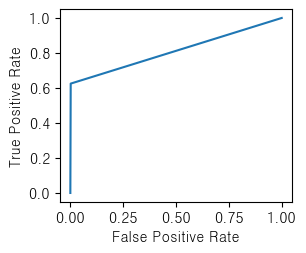

f1 score of decision_tree : 0.67
-----------------------------------------------------
ROC Curve for logistic_regression


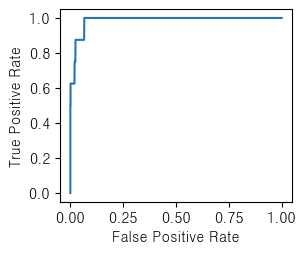

f1 score of logistic_regression : 0.67
-----------------------------------------------------
ROC Curve for SVC


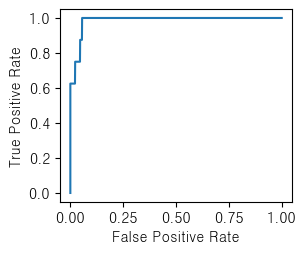

f1 score of SVC : 0.67
-----------------------------------------------------
ROC Curve for random_forest


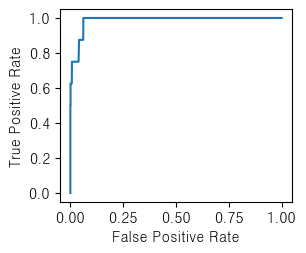

f1 score of random_forest : 0.67
-----------------------------------------------------
ROC Curve for XGBoost


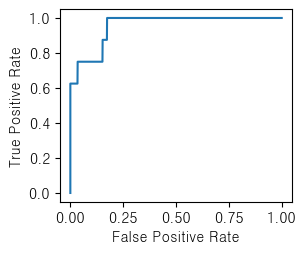

f1 score of XGBoost : 0.67
-----------------------------------------------------
ROC Curve for LightGBM


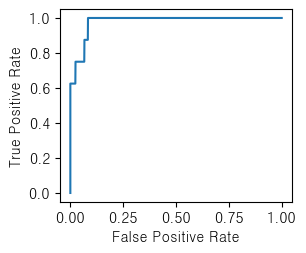

f1 score of LightGBM : 0.67
-----------------------------------------------------
ROC Curve for CatBoost


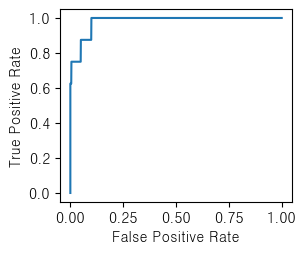

f1 score of CatBoost : 0.71
-----------------------------------------------------


In [21]:
for (name, model) in models.items():
    print(f"ROC Curve for {name}")
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    plot_roc_curve(y_test, y_prob[:, 1])
    f1 = f1_score(y_test, y_pred)
    print(f"f1 score of {name} : {np.round(f1, 2)}")
    print("-----------------------------------------------------")